In [171]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib. patches import Arc
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
import re
import pandas as pd
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
import PIL
from pathlib import Path
sys.path.insert(0, '/path/to/repo/')
import codes.lowmag_analysis_OSS as dio
import codes.various_funcs as var

In [175]:
#########
## get septa trajectory data from TIRF image analysis
#########
path_root = '/path/to/repo/'

path = Path(path_root+'data/TIRF')
folders = [item for item in path.iterdir() if item.is_dir()]
dataframes=[]
for folder in folders:
    for item in folder.iterdir():
        if re.search('septae', item.name) is not None:
            df = pd.read_csv(item)
            df['experiment'] = item.parent.name
            df.drop(columns=['Unnamed: 0'], inplace=True)
            dataframes.append(df)

combined_df_Septae = pd.concat(dataframes, ignore_index=True)      #dataframe containing all of the data in the TIRF folder
unique_experiments_Septae = sorted(pd.unique(combined_df_Septae['experiment'])) #returns SORTED list of unique experiment names
len(combined_df_Septae), unique_experiments_Septae,len(unique_experiments_Septae) 

(198830,
 ['10_Nov_23_TIRF473-7',
  '21_Feb_23_TIRF473-2',
  '21_Feb_23_TIRF473-3',
  '21_Feb_23_TIRF473-6',
  '21_Feb_23_TIRF473-7',
  '21_Feb_23_TIRF473-8',
  '22-Feb-23_tirf-7',
  '22_Feb_23_TIRF473-14',
  '22_Feb_23_TIRF473-17',
  '29_Nov_22_TIRF473'],
 10)

In [151]:
#########
## get blob trajectory data from TIRF image analysis
#########

#path = Path(r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Jerko_files/Manuscript_Code/Jupyter_Notebooks/Analysis/TIRF')
folders = [item.joinpath('tracks') for item in path.iterdir() if item.is_dir()]
dataframes=[]
for folder in folders:
    for item in folder.iterdir():
        if re.search('_filtered', item.name) is not None:
            df = pd.read_csv(item, usecols=['experiment', 'height', 'distance', 'x', 'y', 'particle', 'frame'])
            df = (df[df['height'].abs() < 2]
                    .groupby('particle',group_keys=False)
                    .apply(lambda group: var.calculate_angles(group, min_radius = 1, sample_radius = 3, group_len_thr = 7)) #calculate angles returns arctan of slope between height and distance
                    .reset_index(drop=True)
                    .groupby('particle',group_keys=False)
                    .apply(lambda group: var.calc_speeds(group))
                    .reset_index(drop=True)
                    )
            dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
unique_experiments = sorted(pd.unique(combined_df['experiment'])) #returns list of unique experiment names
all_angles = combined_df.groupby(['experiment', 'particle'],group_keys=False)['angle'].first().values
all_angles_noNA = all_angles[~np.isnan(all_angles)]
len(combined_df),unique_experiments,len(unique_experiments),len(all_angles),len(all_angles_noNA)

/var/folders/gb/2swpg0pd66nb3jkf_7xxbq600000gp/T/ipykernel_81231/1359938115.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: var.calculate_angles(group, min_radius = 1, sample_radius = 3, group_len_thr = 7)) #calculate angles returns arctan of slope between height and distance
/var/folders/gb/2swpg0pd66nb3jkf_7xxbq600000gp/T/ipykernel_81231/1359938115.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to si

(7105,
 ['10-Nov-22_2p-473-TIRF-7',
  '21-Feb-23_TIRF473-2',
  '21-Feb-23_TIRF473-3',
  '21-Feb-23_TIRF473-6',
  '21-Feb-23_TIRF473-7',
  '21-Feb-23_TIRF473-8',
  '22-Feb-23_tirf-14',
  '22-Feb-23_tirf-17',
  '22-Feb-23_tirf-7',
  '29-Nov-22_Todays_Sample_TIRF_473'],
 10,
 369,
 369)

In [177]:
#########
## get associated TIRF movie
#########

experimentOfChoice = 4     #this is 21Feb23-473-7 in both septae and blob data

path_movie = path_root + 'data/'

base_file_septae = unique_experiments_Septae[experimentOfChoice]
base_file_blob = unique_experiments[experimentOfChoice]
path_to_image_stack = path_movie + base_file_blob  + '.tif'

#specify movie parameters
um_per_px = 0.117 #um
dt = 33/1000 #1/33 #sec

# This is to crop the stack, so that we only have the red channel
@pims.pipeline
def red_channel(frame):
    return frame[:,428:]

@pims.pipeline
def green_channel(frame):
    return frame[:,:428]

@pims.pipeline
def normalise(frames):
    #convert image datatype, first to float to normalise and then to uint8
    #first get max pixel value
    k=0
    maxPixel=0
    for frame in frames:
        intPixel = max(frame.flat)
        if intPixel>maxPixel:
            maxPixel=intPixel
            frameID = k
        k=k+1

    #maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
    frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
    frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
    frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
    return frames3

both_channels = pims.open(path_to_image_stack)

# Apply pipeline
images_red = red_channel(both_channels)
images_red_N = normalise(images_red)
images_green = green_channel(both_channels)
images_green_N = normalise(images_green)

base_file_septae, base_file_blob


('21_Feb_23_TIRF473-7', '21-Feb-23_TIRF473-7')

In [178]:
#########
## calculate linear and rot speed from TIRF blob trajectories
#########

from scipy.signal import savgol_filter
from scipy.stats import linregress


def calc_omega_v(group):
    sorted_group = group.sort_values('frame')

    if len(sorted_group) < 7:      #skip trajectory if it has less than 10 data points
    #if len(sorted_group) < 2:    
        sorted_group['v'] = None
        sorted_group['omega'] = None
        return sorted_group

    #fit lines to trajectory horizontal and vertical components, distance and height
    #note that distance is position of blob along the filament long axis (spline) and height is the orthogonal distance to that axis
    horiz_vals = savgol_filter(sorted_group['distance'], window_length=3, polyorder=2) 
    vert_vals = savgol_filter(sorted_group['height'], window_length=3, polyorder=2)

    #get slope of the horizontal line - removed requirement on the correlation to time (it didn't quite make sense to have this)
    slope_h, b_h,r_h , *_ = linregress(sorted_group['frame'], horiz_vals)
   # if r_h > 0.95:
    #if r_h**2 > 0.75:    
    sorted_group['v'] = np.abs(um_per_px*slope_h/dt)        #linear speed is simply the slope of distance - converted to correct units [micron/sec].
   # else:
   #     sorted_group['v'] = None

    #get slope of the vertical line - removed requirement on the correlation to time (it didn't quite make sense to have this)
    slope_v, b_v, r_v, *_ = linregress(sorted_group['frame'],vert_vals)
   # if r_v > 0.95:
    #if r_v**2 > 0.75:
    lin_v = um_per_px*slope_v/dt                        #speed on the orthogonal dimension is the slope of height - converted to correct units.
    sorted_group['omega'] = np.abs(lin_v/0.5)           #angular speed is simply orthogonal speed divided by radius of the cylinder [micron] - results in change of units into [rad/sec]
   # else:
   #     sorted_group['omega'] = None
    #sorted_group['omega'] = np.abs(slope_v)
    
    return sorted_group

omega_df_oss = pd.DataFrame()
for experiment in unique_experiments:
    dataForExperiment = combined_df[combined_df['experiment'] == experiment]
    unique_particles = pd.unique(dataForExperiment['particle']) #returns list of unique particle names for experiment
    for particle in unique_particles:
        dataForParticle = dataForExperiment[dataForExperiment['particle'] == particle]
        omega_df_oss1 = dataForParticle.groupby('particle')[['frame','particle','experiment','distance','height']].apply(lambda group: calc_omega_v(group))[['frame','particle', 'v', 'omega','experiment']].reset_index(drop=True)
        omega_df_oss1 = omega_df_oss1.groupby('particle').first()
        omega_df_oss = pd.concat([omega_df_oss,omega_df_oss1])

omega_df_oss_all = omega_df_oss
#omega_df_oss = omega_df_oss.dropna()
omega_df_oss = omega_df_oss.dropna(subset=['omega'])

slope_oss, b_oss, r_oss, *_ = linregress(omega_df_oss['v'],omega_df_oss['omega'])

len(omega_df_oss_all['v']),len(omega_df_oss['v']), r_oss


(369, 369, 0.9082850233966365)

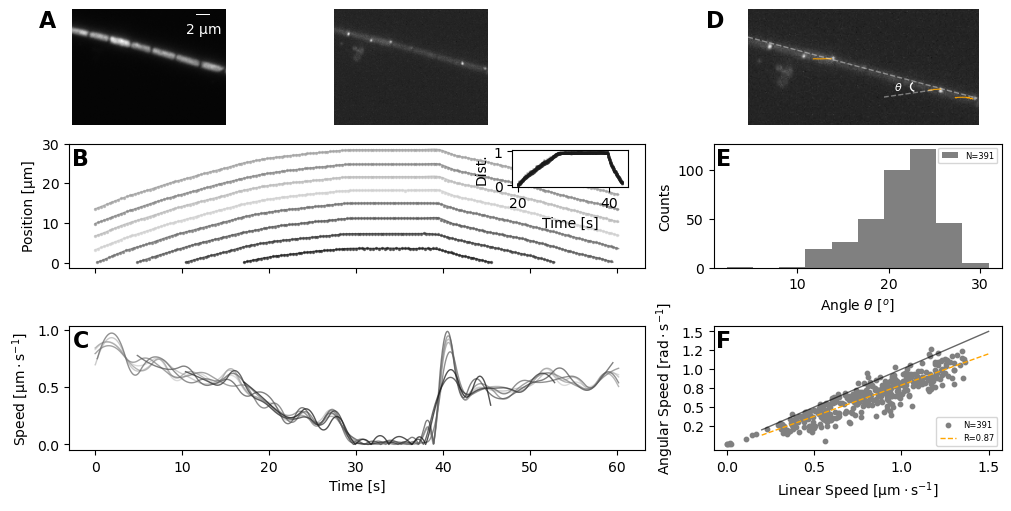

In [247]:
###########
#PLOTTING - WHAT A FANCY PLOT!
###########


#initiate a multi-plot with 2 columns
fig = plt.figure(layout='constrained', figsize=(10, 5))
subfigs = fig.subfigures(2, 1,height_ratios=[0.25,0.75])


###########
#PART A - images 
###########

#create an axis comprising a 1 row 3 column subfigure
axsLeft = subfigs[0].subplots(1, 4, gridspec_kw={'width_ratios': [1.2,1, 0.7,1.2]}) #sharex=True,sharey=True
axsLeft[0].text(-0.1, 1, 'A', transform=axsLeft[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

#decide time points for frames to show
t1=1200
t2=2000

#show first image
frameToShow_G = images_green_N[t1]
frameToShow_R = images_red_N[t1]
axsLeft[0].imshow(frameToShow_R,cmap='gray')

limX1, limX2 = 200, 400
limY1, limY2 = 300, 450 #200,500
axsLeft[0].set_xlim([limX1, limX2])
axsLeft[0].set_ylim([limY1, limY2])
axsLeft[0].yaxis.set_inverted(True) 

#add scale bar
scalebar = ScaleBar(um_per_px*10**-6,location="upper right",color='w',frameon=False) # 1 pixel = 0.2 meter
axsLeft[0].add_artist(scalebar)

#show second image
axsLeft[1].imshow(frameToShow_G,cmap='gray')

axsLeft[1].set_xlim([limX1, limX2])
axsLeft[1].set_ylim([limY1, limY2])
axsLeft[1].yaxis.set_inverted(True) 

#show third image
axsLeft[3].text(-0.1, 1, 'D', transform=axsLeft[3].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axsLeft[3].imshow(frameToShow_G,cmap='gray')

#gather data from specified experiment and for all particles found there
dataForExperiment = combined_df[combined_df['experiment'] == base_file_blob]
unique_particles2 = pd.unique(dataForExperiment.loc[dataForExperiment['experiment']==base_file_blob, 'particle'])

meParticles = []
for k,x in enumerate(unique_particles2):
     sub_df = dataForExperiment.loc[(dataForExperiment['particle'] == x)]
     time_axis = sub_df['frame'].values #frame id
     posX = sub_df['x'].values[np.where((time_axis>t1) & (time_axis<t2))]
     posY = sub_df['y'].values[np.where((time_axis>t1) & (time_axis<t2))]
     if (len(posY)>10): meParticles = np.append(meParticles,x)
     #posX = sub_df['x'].values
     #posY = sub_df['y'].values
     if (x == 992 or x == 1009 or x == 1016):
          axsLeft[3].plot(posX,posY,linewidth=0.75,color = 'orange', alpha=1,label = f'Particle {x}')

axsLeft[3].set_xlim([limX1, limX2])
axsLeft[3].set_ylim([limY1, limY2-50])
axsLeft[3].yaxis.set_inverted(True) 

myX = np.arange(200, 400, 3.75)
myY = range(324,378,1)
axsLeft[3].plot(myX,myY, '--', color='white', alpha = 0.4,linewidth = 1)
myX = range(360,312,-7)
myY = range(370,377,1)
axsLeft[3].plot(myX,myY, '--', color='white', alpha = 0.4,linewidth = 1)
axsLeft[3].add_patch(Arc((345, 367), 8, 8, theta1=100, theta2=-118,
                     edgecolor='white', facecolor='none', lw=1))
axsLeft[3].annotate(r'$\theta$', (345-15, 367), color='white', va="center", ha="center",fontsize=8)

axsLeft[0].axis('off')
axsLeft[1].axis('off')
axsLeft[2].axis('off')
axsLeft[3].axis('off')

###################################
#position and speed analysis for septae
###################################


#key PARAMETERS to set
spline_k = 3                    #what order should we use when fitting the spline
spacing = 1                     #spacing to use for the gradient function used for speed calc
speedLimit = 0.2               #what speed limit we should use to decide "dwell" (i.e. reversal)
sparsity = 50 
sparsity2 = 10 

experiment_septae = unique_experiments_Septae[experimentOfChoice] #21Feb23-473-7 

#gather data from specified experiment and for all particles found there
dataForExperiment = combined_df_Septae[combined_df_Septae['experiment'] == experiment_septae]
unique_particles2 = pd.unique(dataForExperiment.loc[dataForExperiment['experiment']==experiment_septae, 'particle'])

#colors = plt.cm.inferno(np.linspace(0.3,1,len(unique_particles2)+1))
colors = plt.cm.Greys(np.linspace(0.3,1,len(unique_particles2)+1))

#axsLeftBot = subfigs[1,0].subplots(2, 1,sharex=True)
axsLeftBot = subfigs[1].subplots(2, 2,gridspec_kw={'width_ratios': [2, 1]})

ins = axsLeftBot[0,0].inset_axes([0.77,0.65,0.2,0.3])
t1=600
t2=1300
for k,x in enumerate(unique_particles2):
    sub_df = dataForExperiment.loc[(dataForExperiment['particle'] == x)]
    time_axis = sub_df['frame'].values #frame ids
    pos_axis = um_per_px*sub_df['distance'].values #um
    pos_axis_partial = pos_axis[np.where((time_axis>t1) & (time_axis<t2))]
    distTravelled_norm = (pos_axis_partial-min(pos_axis_partial))/(max(pos_axis_partial)-min(pos_axis_partial))

    frame_ids = np.arange(0, len(pos_axis),1)           #create a x-axis array based on frames 
    frame_ids_sparse = np.arange(0, len(pos_axis),sparsity)      #create a sparse x-axis
    frame_ids_sparse2 = np.arange(0, len(pos_axis),sparsity2)      #create a sparse x-axis
    if frame_ids_sparse[-1] != len(pos_axis)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(pos_axis)-1)  #make sure last frame id is included in the sparse set

    #remove indices with nan values from sparse used for centre spline
    nanIndices = np.where(np.isnan(pos_axis[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
    frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

    #spline fitting
    splineC_dist = interpolate.splrep(frame_ids_sparse_C,pos_axis[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
    centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

    #speed from fitted dist-coordinate
    speed = np.abs(np.gradient(centre_dist_fitted,spacing)/dt)

    #plot
    #ax[0].scatter(time_axis[frame_ids_sparse2]*dt, pos_axis[frame_ids_sparse2],marker='o', s=2,color = colors[k], alpha=0.6,label = f'Particle {x}')
    #ax[0].plot(time_axis*dt, centre_dist_fitted,linewidth=1,color = colors[k], alpha=0.7,label = f'Particle {x}')
    axsLeftBot[0,0].scatter(time_axis[frame_ids_sparse2]*dt, pos_axis[frame_ids_sparse2],marker='o', s=2,color = colors[k], alpha=0.6,label = f'Particle {x}')
    axsLeftBot[0,0].plot(time_axis*dt, centre_dist_fitted,linewidth=1,color = colors[k], alpha=0.7,label = f'Particle {x}')
    ins.scatter(time_axis[np.where((time_axis>t1) & (time_axis<t2))]*dt, distTravelled_norm,marker='o', s=1,color = colors[k], alpha=0.25,label = f'Particle {x}')
    #ax[1].plot(time_axis*dt, speed, linewidth=1,color = colors[k], alpha=0.75, label = f'Particle {x}')
    axsLeftBot[1,0].plot(time_axis*dt, speed, linewidth=1,color = colors[k], alpha=0.75, label = f'Particle {x}')

axsLeftBot[0,0].text(0.035, .97, 'B', transform=axsLeftBot[0,0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
#axsLeftBot[0].set_title(experiment_septae)
axsLeftBot[0,0].set_ylabel('Position [μm]')
#axsLeftBot[0,0].set_xlabel('Time [sec]')
ins.set_ylabel('Dist.')
ins.set_xlabel('Time [s]')
axsLeftBot[1,0].set_ylabel(r'Speed [$\rm \mu m \cdot s^{-1}$]')
axsLeftBot[1,0].set_xlabel('Time [s]')
axsLeftBot[1,0].text(0.035, 0.97, 'C', transform=axsLeftBot[1,0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

axsLeftBot[0,0].set_xticklabels([])

len(unique_particles2), len(time_axis)


axsLeftBot[0,1].hist(all_angles,bins=10, density=False, color='gray',label='N=391')
axsLeftBot[0,1].set_ylabel('Counts')
axsLeftBot[0,1].set_xlabel(r'Angle $\theta$ [$^o$]')
axsLeftBot[0,1].legend(loc="upper right",fontsize=6)
axsLeftBot[0,1].text(0.06, 0.97, 'E', transform=axsLeftBot[0,1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')


x_vals = np.linspace(0.2, 1.5, 500)
axsLeftBot[1,1].scatter(omega_df_oss['v'], omega_df_oss['omega'], marker='o', s=10,color='gray',label='N=391')
axsLeftBot[1,1].plot(x_vals, slope_oss*x_vals + b_oss, '--', color='orange', alpha = 1,linewidth = 1,label='R=0.87')
axsLeftBot[1,1].plot(x_vals, x_vals, '-', color='k', alpha = 0.6,linewidth = 1)
axsLeftBot[1,1].set_ylabel(r'Angular Speed [$\rm rad \cdot s^{-1}$]')
axsLeftBot[1,1].set_xlabel(r'Linear Speed [$\rm \mu m \cdot s^{-1}$]')
axsLeftBot[1,1].set_yticks([0.25,0.5,0.75,1.00,1.25,1.50])
axsLeftBot[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axsLeftBot[1,1].legend(loc="lower right",fontsize=6)
axsLeftBot[1,1].text(0.06, 0.97, 'F', transform=axsLeftBot[1,1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

#fig.savefig('Fig4_RoskoEtal.pdf',dpi = 300,bbox_inches = 'tight')
plt.show()
plt.close(fig)

In [163]:
np.mean(all_angles)

21.27956901923584